# CS105 Survey
Members: John Huh, Emily Mai, Calvin Ng

# Data Pre-processing

In [256]:
# import necessary libraries
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
import umap
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import networkx as nx
%matplotlib inline

In [2]:
# load the data
def load_data(start=0, end=10000, path="data/yelp_academic_dataset_review.json"):
    datafile = open(path, encoding='utf-8')
    data = []
    for i, line in tqdm(enumerate(datafile)):
        if i in list(range(start, end)):
            data.append(json.loads(line))
        if i > end:
            break
    datafile.close()
    df = pd.DataFrame(data)
    return df

# Text Embedding

In [3]:
# function to embedd the reviews
def load_embeddings(dataframe, column):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    messages = np.asarray(dataframe[column])
    tensor_list = tf.convert_to_tensor(messages)
    embeddings = np.array(embed(tensor_list)).tolist()
    # return the reviews followed by their respective embeddings
    return messages, embeddings

# function to show the embeddings
def show_embeddings(n, reviews, embeddings):
    # print first n review embeddings
    for i, message_embedding in enumerate(embeddings[:n]):
        print("Message: {}".format(reviews[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Batch Processing

In [5]:
# function to process batches of the data
def batch_process(step=10000, stop=50000):
    review_df = pd.DataFrame()
    # generate ranges (i.e. [(0,1000), (1000,2000), ...]
    batches = [(n, min(n + step, stop)) for n in range(0, stop, step)]
    for s, e in batches:
        print("Processing {}:{}...".format(s, e))
        # load data and embeddings
        df = load_data(s, e)
        text, embeddings = load_embeddings(df, "text")
        # store embeddings in dataframe
        df["embedding"] = embeddings
        # add new embeddings to main dataframe
        review_df = pd.concat([review_df, df], ignore_index=True, sort=False)

    # save to pickle file to avoid reprocessing of embeddings
    review_df.to_pickle("data/data.pkl")
    print(review_df)


# batch_process()

# if you have the pkl file just run this:
# review_df = pd.read_pickle("data/data.pkl")
# review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,embedding
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,"[-0.018010487779974937, -0.050318099558353424,..."
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,"[-0.04308006912469864, -0.019955946132540703, ..."
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,"[-0.01958566904067993, -0.04187788814306259, -..."
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,"[-0.044252898544073105, -0.07447142153978348, ..."
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,"[0.013128811493515968, -0.01807524263858795, 0..."


# Reviews Clustering

In [203]:
# clustering using Gaussian Mixture Models
# grid search hyper-parameters and return best model and scores
def gmm_model_selection(n_clusters, X):
    lowest_bic = np.infty
    bic = []
    assert X.shape[0] >= n_clusters
#     cv_types = ['spherical', 'tied', 'diag', 'full']
#     for cv_type in cv_types:
    cv_type = 'diag'
    for k in range(1, n_clusters):
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    print("Num components chosen by GMM: {}".format(best_gmm.n_components))
    return best_gmm, bic

# clustering using DBSCAN
# grid search hyper-parameters and return best model and scores
def dbscan_model_selection(X):
    lowest_ss = np.infty
    scores = []
    for epsilon in [0.85, 0.9, .95, 1]:
        score_row = []
        for min_samples in [3, 5, 7, 9]:
            db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
            labels = db.labels_
            score_row.append(metrics.silhouette_score(X, labels))
            if score_row[-1] < lowest_ss:
                lowest_ss = score_row[-1]
                best_db = db
        scores.append(score_row)
    labels = best_db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    return best_db, np.array(scores)

# visualization for clusters
def plot_tsne(gmm, X, Y, messages):
    # dimensionality reduction
    x_reduced = TSNE(n_components=2).fit_transform(X)

    # plot points and their respective colors according to cluster
    color_iter = iter([plt.cm.tab20(i) for i in range(20)])
#     color_iter = itertools.cycle(['lightblue', 'lightgreen', 'darkorange', 'grey', 'purple', 'darkgreen', 'darkblue','darkred','pink'])
    for i, mean in enumerate(gmm.means_):
        if not np.any(Y == i):
            continue
        plt.scatter(x_reduced[Y == i, 0], x_reduced[Y == i, 1], 8, color=next(color_iter))
    csr = mplcursors.cursor(hover=True)
    csr.connect("add", lambda sel: sel.annotation.set_text(messages[sel.target.index]))
    plt.xticks(())
    plt.yticks(())
    plt.title(f'Selected GMM: {gmm.covariance_type} model, 'f'{gmm.n_components} components')
    plt.show()

In [219]:
# load data for one business
data = pd.read_pickle("data/data.pkl")
data = data[data["business_id"] == "bZiIIUcpgxh8mpKMDhdqbA"]
X = np.array(data["embedding"].tolist())
# X = TSNE(n_components=2).fit_transform(X)
X = umap.UMAP(n_components=10).fit_transform(X)

Num components chosen by GMM: 16


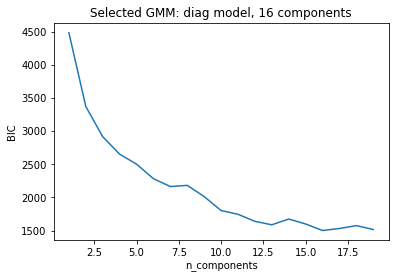

In [222]:
# run once to get best model using GMMs
best_gmm, bic = gmm_model_selection(20, X)
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, 'f'{best_gmm.n_components} components')
plt.plot(np.arange(1,20), bic)
plt.xlabel("n_components") 
plt.ylabel("BIC") 
plt.show()

# run once to get best model using DBSCAN
# best_db, scores = dbscan_model_selection(X)
# labels = best_db.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# plt.title('Selected DBSCAN: epsilon={}, min_samples={}, {} components, {} outliers'.format(best_db.eps,best_db.min_samples,n_clusters_,n_noise_))
# ax = sns.heatmap(scores, linewidth=0.3, xticklabels=[3, 5, 7, 9], yticklabels=[0.85, 0.9, .95, 1])
# plt.xlabel("min_samples") 
# plt.ylabel("epsilon") 
# plt.show()

In [325]:
# fit and predict GMM on data
model = GaussianMixture(n_components=10, covariance_type='diag', tol=1e-6, max_iter=10000, verbose=2)
best_gmm = model.fit(X)
Y = best_gmm.predict(X)  # contains generated cluster labels

Initialization 0
  Iteration 10	 time lapse 0.26299s	 ll change 0.00009
  Iteration 20	 time lapse 0.03502s	 ll change 0.00001
  Iteration 30	 time lapse 0.05696s	 ll change 0.00000
  Iteration 40	 time lapse 0.02901s	 ll change 0.00000
Initialization converged: True	 time lapse 0.38497s	 ll -0.84072


# Anomaly Detection

In [126]:
def gmm_anomalies(data, posterior, threshold):
    max_posterior = np.amax(posterior, axis=1)
    indices = np.argwhere(max_posterior < threshold).flatten()
    anomalies = data["text"].take(indices)
    return anomalies

def lof_anomalies(data, X):
    model = LocalOutlierFactor(contamination=0.01, n_neighbors=5, metric="l2")
    outlier_scores = model.fit_predict(X)
    print(model.negative_outlier_factor_[outlier_scores == -1])
    anomalies = data[outlier_scores == -1]
    return anomalies["text"]

def dbscan_anomalies(labels):
    indices = np.argwhere(labels == -1).flatten()
    anomalies = data["text"].take(indices)
    return anomalies

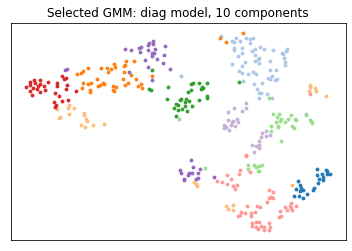

In [328]:
# X = umap.UMAP(n_components=4).fit_transform(X)
# anomalies = gmm_anomalies(data, best_gmm.predict_proba(X), 0.99)
# anomalies = dbscan_anomalies(labels)
# print(anomalies)
# print(lof_anomalies(data,X))

# generate plot using TSNE
plot_tsne(best_gmm, X, Y, data["text"])

In [329]:
texts = data["text"].take(np.argwhere(Y==6).flatten())
stars = data["stars"].take(np.argwhere(Y==6).flatten())

for t,s in zip(texts,stars):
    print("START--------------------")
    print(s, t)
    print("END----------------------\n")

START--------------------
4.0 Popped in one night about an hour before Closing. Found out ,with a stamped ticket, Parking is free for 2 hours. A, plus. Stood in line for about 15 minutes, then the door matron let me in, to stand in another line(very long). Was chatting with a couple in line and, one of them said you can sit at the bar and get quicker service. So I sauntered over to the one remaining seat. The bartender was friendly, took my order. Only waited about 15 minutes and the food was brought out on a metal tray. BTW, they have Stevia and Sugar in the Raw for sweeteners. A-plus. The Burger (a Classic, )was good. Fries were over cooked. Got out for around $16.
END----------------------

START--------------------
4.0 Still a good burger, but the experience has started to slide.  Lot's of signs with rules, limitations, etc.  No more smiling server greeting you in line to get a drink order.
END----------------------

START--------------------
5.0 So what is a "Hopdoddy" you ask, we

# Cluster Summarization

In [316]:
def read_article(texts):
    combined_text = ' '.join(texts)
    reviews = combined_text.split(". ")
    sentences = []
    for sentence in reviews:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix

def generate_summary(texts, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []
    # Step 1 - Read text and tokenize
    sentences =  read_article(texts)
    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph, max_iter=100)
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
#     print("Indexes of top ranked_sentence order are ", ranked_sentence)
    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
        # Step 5 - Offcourse, output the summarize texr
    return ". ".join(summarize_text)

In [ ]:
for c in range(20):
    indices = np.argwhere(Y == c).flatten()
    mean = data["stars"].take(indices).sum() / len(indices)
    cluster_text = data["text"].take(np.argwhere(Y==c).flatten()).tolist()
    print("Summary of cluster {} w/ {} reviews and avg. rating of {}:".format(c, len(indices), mean))
    try:
        summary = generate_summary(cluster_text, top_n=5)
        print(summary)
    except:
        print("Runtime error :(")
        continue


Summary of cluster 0 w/ 23 reviews and avg. rating of 4.434782608695652:
Best burger place in Austin.  The line generally goes pretty quick, and you can grab a beer while you are in line ;) One of the best burgers in Austin. Best modern burger in austin by far. Best burgers in Austin. Hopdoddy is probably my favorite burger place in Texas! Absolutely LOVE all the eclectic burgers
Summary of cluster 1 w/ 58 reviews and avg. rating of 4.517241379310345:
  Poblano burger very good.  Hopdoddy and IN-N-OUT are the best burger places ever.
Best burgers in Austin!!! 
Get the chili cheese fries they are magical!! 
Every burger is cooked perfectly and the buns are really good.  Also, the Parmesan Truffle fries are to die for!  My family & I love this place!!! Be prepared to wait in line for 45-1hr but it will definitely be worth it!!! I ordered the classic burger with added bacon and a fried egg.   Had to try the prime time burger.  Classic burger so good
Summary of cluster 2 w/ 42 reviews and 

C:\Users\Emily Mai\anaconda3\lib\site-packages\nltk\cluster\util.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))
